In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from sympy import integrate, exp, sin, log, oo, pi,symbols
import deepxde as dde
import scipy.io as scio
from mpl_toolkits.mplot3d import Axes3D
from deepxde.backend import tf
#import datetime
# import time
import os
from pylab import mpl
import pandas as pd
from scipy.signal import chirp, spectrogram
mpl.rcParams['font.sans-serif']=['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus']=False
from matplotlib.pyplot import MultipleLocator
# import xlrd
# import xlwt
from sympy import *
import sympy as sp
# import torch

2025-04-08 09:35:02.542269: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


2025-04-08 09:35:03.277164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-08 09:35:03.280522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-08 09:35:03.280588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Enable just-in-time compilation with XLA.




In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
 
from matplotlib import rcParams
 
config = {
            "font.family": 'serif',
            "font.size": 10.5,
            "mathtext.fontset": 'stix',
            "font.serif": ['MicroSoft YaHei'],
         }
rcParams.update(config)

In [5]:
x_vals = np.arange(0, 1.01, 0.01)
y_vals = np.arange(0, 1.01, 0.01)
x, y = np.meshgrid(x_vals, y_vals)
ob_x = x.ravel()
ob_y = y.ravel()
X = np.column_stack((ob_x, ob_y))

file_name = 'Plate_D_v0.3.mat'
data_matlab = scio.loadmat(file_name)
Dis_all = -data_matlab["Dis"].reshape(-1,1)/1000


data_comsol = np.genfromtxt("Plate_damage.txt", comments="%")
x_data = data_comsol[:, 0:1]
y_data = data_comsol[:, 1:2]
value_data = data_comsol[:, 2:3]

from scipy.interpolate import griddata
xi = np.linspace(0, 1, 1000)  # x轴范围
yi = np.linspace(0, 1, 1000)  # y轴范围
xi, yi = np.meshgrid(xi, yi)

matlab_interp = griddata((ob_x, ob_y), Dis_all, (xi, yi), method='linear')
comsol_interp = griddata((x_data.ravel(), y_data.ravel()), value_data, (xi, yi), method='linear')
residual = abs(comsol_interp - matlab_interp)

In [38]:
data_comsol = np.genfromtxt("Plate_damage.txt", comments="%")
x_data = data_comsol[:, 0:1]
y_data = data_comsol[:, 1:2]
value_data = data_comsol[:, 4:5]

from scipy.interpolate import griddata
xi = np.linspace(0, 1, 1000)
yi = np.linspace(0, 1, 1000)
xi, yi = np.meshgrid(xi, yi)

comsol_interp = griddata((x_data.ravel(), y_data.ravel()), value_data, (xi, yi), method='linear')

In [8]:
def Solution(x=0.15,y=-1):
    file_name='Plate_D_v0.3.mat'
    data = scio.loadmat(file_name)
    exact = -data["Dis"]/1000
    grid = np.linspace(0,1,101).reshape(-1,1)
    if y == -1:
        index = round(x/0.01)
        return np.hstack((grid*0+x, grid, exact[:,index].reshape(-1,1)))
    if x == -1:
        index = round(y/0.01)
        return np.hstack((grid, grid*0+y, exact[index,:].reshape(-1,1)))
def get_observe_u1():
    file_name = 'Plate_D_v0.3.mat'
    All_w_data = scio.loadmat(file_name)
    All_w_data = All_w_data["Dis"]
    w_x = [0.1, 0.2, 0.3, 0.4]  # [0.2, 0.4, 0.6, 0.8]
    w_y = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # [0.2, 0.4, 0.6, 0.8]
    index_x = np.round(np.array(w_x) / 0.01).astype(int)
    index_y = np.round(np.array(w_y) / 0.01).astype(int)
    Observe = All_w_data[index_y[:, None], index_x]
    ob_x, ob_y = np.meshgrid(w_x, w_y)
    ob_x =  ob_x.flatten()
    ob_y =  ob_y.flatten()
    X = np.hstack((ob_x.reshape(-1, 1), ob_y.reshape(-1, 1) ,Observe.reshape(-1, 1) / 1000 * -1))
    return X
ob_x1,ob_y1 = get_observe_u1()[:,0:2],get_observe_u1()[:,2:3]
# ob_y = W_func(ob_x[:,0:1], ob_x[:,1:2])
observe_u1 = dde.PointSetBC(ob_x1,ob_y1,component=0)

def get_observe_u2():
    file_name = 'Plate_D_v0.3.mat'
    All_w_data = scio.loadmat(file_name)
    All_w_data = All_w_data["Dis"]
    w_x = [0.6, 0.7, 0.8, 0.9]  # [0.2, 0.4, 0.6, 0.8]
    # w_y = [0.15, 0.25, 0.5, 0.75, 0.85]  # [0.2, 0.4, 0.6, 0.8]
    w_y = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # [0.2, 0.4, 0.6, 0.8]
    index_x = np.round(np.array(w_x) / 0.01).astype(int)
    index_y = np.round(np.array(w_y) / 0.01).astype(int)
    Observe = All_w_data[index_y[:, None], index_x]
    ob_x, ob_y = np.meshgrid(w_x, w_y)
    ob_x =  ob_x.flatten()
    ob_y =  ob_y.flatten()
    X = np.hstack((ob_x.reshape(-1, 1), ob_y.reshape(-1, 1) ,Observe.reshape(-1, 1) / 1000 * -1))
    return X
ob_x2,ob_y2 = get_observe_u2()[:,0:2],get_observe_u2()[:,2:3]
# ob_y = W_func(ob_x[:,0:1], ob_x[:,1:2])
observe_u2 = dde.PointSetBC(ob_x2,ob_y2,component=1)

In [9]:
L_x = 1
L_y = 1
x = np.linspace(0,1,400)
anchors_xy = np.vstack((np.random.uniform(0,L_x,2000),np.random.uniform(0,L_y,2000))).T
anchors_xy1 = np.vstack(( x, x )).T
anchors_xy2 = np.vstack(( x, -x+1 )).T
anchors_xy =  np.vstack(( anchors_xy, anchors_xy1,anchors_xy2 ))

In [11]:
np.random.seed(1234)
tf.set_random_seed(1234)
#模型训练
num_domain = 0   
epochs = 10000
lr = 1e-3
u_nodenum=20
u_layer=2
E_nodenum=20
E_layer=2
activation_func1 = tf.nn.tanh
activation_func2 = tf.nn.tanh

L_x = 1
L_y = 1
h = 0.005
#T = 1
#rho = 7800
v = 0.3
E = 2.06e11
D_true = E*h**3/12/(1-v**2)
q = 1000

x = np.linspace(0,1,400)
anchors_xy = np.vstack((np.random.uniform(0,L_x,2000),np.random.uniform(0,L_y,2000))).T
anchors_xy1 = np.vstack(( x, x )).T
anchors_xy2 = np.vstack(( x, -x+1 )).T
anchors_xy =  np.vstack(( anchors_xy))

def TF_Q(x_in):
    f = q*tf.ones_like(x_in)
    return f

def NP_Q(x_in):
    f = q*np.ones_like(x_in)
    return f

def NP_K(x_in):
    K1 = 0
    f = K1*np.ones_like(x_in)
    return f
def D_true_func(x,y):
    condition = np.logical_and( 0.5 <= x, x < 1.1)
    f = np.where(condition, 0.5*np.ones_like(x),  np.ones_like(y))
    return f

def D_true_func_TF(x,y):
    condition = tf.logical_and( 0.5 <= x, x < 1.1)
    f = tf.where(condition, 0.5*tf.ones_like(x),  tf.ones_like(y))
    return f

def f(x_in):
    x1_in = x_in[:, 0:1]
    x2_in = x_in[:, 1:2]    
    condition = tf.logical_and(tf.logical_and(0 < x1_in, x1_in < 1), tf.logical_and(0 < x2_in, x2_in < 1))
    f = tf.where(condition, tf.ones_like(x1_in),  tf.ones_like(x1_in))
    return f
c1 = (tf.Variable(0.01, trainable=True, dtype=tf.float32))
c2 = (tf.Variable(0.01, trainable=True, dtype=tf.float32))
c3 = (tf.Variable(0.01, trainable=True, dtype=tf.float32))
c4 = (tf.Variable(100, trainable=True, dtype=tf.float32))
c5 = (tf.Variable(100, trainable=True, dtype=tf.float32))
c6 = (tf.Variable(100, trainable=True, dtype=tf.float32))

s1 = (tf.Variable(0.5, trainable=False, dtype=tf.float32))

num_NN = 2

D1_unkown = (tf.Variable(2, trainable=True, dtype=tf.float32))
D2_unkown = (tf.Variable(2, trainable=True, dtype=tf.float32))
D_list = [D1_unkown, D2_unkown]

def platepde(x, y):
    D_true = E*h**3/12/(1-v**2)
    x_in = x
    x1_in = x[:,0:1]
    x2_in = x[:,1:2]
    u       = y[:, 0: num_NN ]      
    Fai_x   = y[:, 1*num_NN: 2*num_NN]
    Fai_y   = y[:, 2*num_NN: 3*num_NN]
    Dfai_x  = y[:, 3*num_NN: 4*num_NN]
    Dfai_y  = y[:, 4*num_NN: 5*num_NN]
    M_x     = y[:, 5*num_NN: 6*num_NN]
    M_y     = y[:, 6*num_NN: 7*num_NN]
    V_x     = y[:, 7*num_NN: 8*num_NN]
    V_y     = y[:, 8*num_NN: 9*num_NN]
    D      =  y[:, 9*num_NN: 10*num_NN]
    D_true = E*h**3/12/(1-v**2)
    Fai_x_dNN = []
    Fai_y_dNN = []
    Dfai_x_dNN = []
    Dfai_y_dNN = []
    Dfai_xy_dNN = []
    M_x_dNN = []
    M_y_dNN = []
    V_x_dNN = []
    V_y_dNN = []
    Pde_dNN = []
    Q_xy_dNN = []
    
    D_xx_dNN = []
    D_yy_dNN = []
    
    for i in range(num_NN):
        fai_x_dNN = - dde.grad.jacobian(u, x, i = i, j=0)
        fai_y_dNN = - dde.grad.jacobian(u, x, i = i, j = 1)
        
        dfai_x_dNN = dde.grad.jacobian(Fai_x, x, i = i, j = 0)    
        dfai_y_dNN = dde.grad.jacobian(Fai_y, x, i = i, j = 1)
        
        dfai_xy_dNN = dde.grad.jacobian(Fai_x, x, i = i, j = 1)
        dfai_yx_dNN = dde.grad.jacobian(Fai_y, x, i = i, j = 0)
        
        m_x_dNN = D_list[i] * D_true * Dfai_x[:,i:i+1]     
        m_y_dNN = D_list[i] * D_true * Dfai_y[:,i:i+1]
        
        v_x_dNN = dde.grad.jacobian(M_x, x, i = i, j = 0)
        v_y_dNN = dde.grad.jacobian(M_y, x, i = i, j = 1)
        
        q_x_dNN = - dde.grad.jacobian(V_x, x, i = i, j = 0)
        q_y_dNN = - dde.grad.jacobian(V_y, x, i = i, j = 1)
        
        q_xxyy_dNN = -dde.grad.hessian(M_x, x, component=i, i = 1, j = 1)
        q_yyxx_dNN = -dde.grad.hessian(M_y, x, component=i, i = 0, j = 0)

        Fai_x_dNN.append(fai_x_dNN)
        Fai_y_dNN.append(fai_y_dNN)
        Dfai_x_dNN.append(dfai_x_dNN)
        Dfai_y_dNN.append(dfai_y_dNN)
        Dfai_xy_dNN.append(dfai_xy_dNN-dfai_yx_dNN)
        M_x_dNN.append(m_x_dNN)
        M_y_dNN.append(m_y_dNN)
        V_x_dNN.append(v_x_dNN)
        V_y_dNN.append(v_y_dNN)
        Pde_dNN.append(q_x_dNN + 2*q_xxyy_dNN + q_y_dNN - q)
        Q_xy_dNN.append(q_xxyy_dNN-q_yyxx_dNN)
    
    loss_Fai_x = 0
    loss_Fai_y = 0
    loss_Dfai_x = 0
    loss_Dfai_y = 0
    loss_Dfai_xy = 0
    loss_M_x = 0
    loss_M_y = 0
    loss_V_x = 0
    loss_V_y = 0
    loss_Pde = 0
    loss_Q_xy = 0
    
    f_sig = []
    f_sig.append( tf.sign( tf.nn.relu(-(x1_in-s1)) ) )
    f_sig.append( tf.sign( tf.nn.relu( (x1_in-s1)) ) )
    
    for i in range(num_NN):
        Weight_Mx =  tf.sign (tf.tanh(tf.nn.relu( tf.abs(M_x[:,i:i+1]) - 5)))
        Weight_My =  tf.sign (tf.tanh(tf.nn.relu( tf.abs(M_y[:,i:i+1]) - 5)))
        
        loss_Fai_x   = loss_Fai_x   + (Fai_x[:,i:i+1]-Fai_x_dNN[i])   * f_sig[i]
        loss_Fai_y   = loss_Fai_y   + (Fai_y[:,i:i+1]-Fai_y_dNN[i])   * f_sig[i]
        loss_Dfai_x  = loss_Dfai_x  + (Dfai_x[:,i:i+1]-Dfai_x_dNN[i]) * f_sig[i] * Weight_Mx
        loss_Dfai_y  = loss_Dfai_y  + (Dfai_y[:,i:i+1]-Dfai_y_dNN[i]) * f_sig[i] * Weight_My
        loss_Dfai_xy = loss_Dfai_xy +  Dfai_xy_dNN[i]                 * f_sig[i]
        loss_M_x     = loss_M_x     + (M_x[:,i:i+1]-M_x_dNN[i])       * f_sig[i]
        loss_M_y     = loss_M_y     + (M_y[:,i:i+1]-M_y_dNN[i])       * f_sig[i]
        loss_V_x     = loss_V_x     + (V_x[:,i:i+1]-V_x_dNN[i])       * f_sig[i]
        loss_V_y     = loss_V_y     + (V_y[:,i:i+1]-V_y_dNN[i])       * f_sig[i]
        loss_Pde     = loss_Pde     +  Pde_dNN[i]                     * f_sig[i]
        loss_Q_xy    = loss_Q_xy    +  Q_xy_dNN[i]                    * f_sig[i]
        
    return [loss_Fai_x, loss_Fai_y, loss_Dfai_x, loss_Dfai_y, loss_Dfai_xy, loss_M_x/D_true, loss_M_y/D_true,\
            loss_V_x/D_true, loss_V_y/D_true, 1e-1*loss_Pde/D_true, loss_Q_xy/D_true]

geom = dde.geometry.Rectangle([0, 0], [1, 1])

K1 = 0
K2 = 0
K3 = 0
K44 = 0

data = dde.data.pde.PDE(geom,platepde,[observe_u1,observe_u2], num_domain=num_domain,anchors=anchors_xy)
net = dde.maps.FNN([2]  + [100]*3 + [10*num_NN], "tanh", "Glorot uniform")
def modify_output(X, y):
    x1      = X[:,0:1]
    x2      = X[:,1:2]
    u       = y[:, 0*num_NN: 1*num_NN ]      
    Fai_x   = y[:, 1*num_NN: 2*num_NN]
    Fai_y   = y[:, 2*num_NN: 3*num_NN]
    Dfai_x  = y[:, 3*num_NN: 4*num_NN]
    Dfai_y  = y[:, 4*num_NN: 5*num_NN]
    M_x     = y[:, 5*num_NN: 6*num_NN]
    M_y     = y[:, 6*num_NN: 7*num_NN]
    V_x     = y[:, 7*num_NN: 8*num_NN]
    V_y     = y[:, 8*num_NN: 9*num_NN]
    D       = y[:, 9*num_NN: 10*num_NN]
    Hard_BC = tf.layers.dense(x2, E_nodenum, activation_func2)  
    for i in range(2):
        Hard_BC = tf.layers.dense(Hard_BC, E_nodenum, activation_func2)
    Hard_BC = tf.layers.dense(Hard_BC, 10, None)
    
    u1       = c1 * (u[:,0:1]*(x1-  0)*(x1-s1)      + Hard_BC[:,0:1]*(x1-  0)/(s1-  0) ) * (x2-0)*(x2-L_y)
    u2       = c1 * (u[:,1:2]*(x1-L_x)*(x1-s1)      + Hard_BC[:,0:1]*(x1-L_x)/(s1-L_x) ) * (x2-0)*(x2-L_y)
    Fai_x1   = c2 * (Fai_x[:,0:1]*(x1-s1)           + Hard_BC[:,1:2]) * (x2-0)*(x2-L_y)
    Fai_x2   = c2 * (Fai_x[:,1:2]*(x1-s1)           + Hard_BC[:,1:2]) * (x2-0)*(x2-L_y)
    Fai_y1   = c2 * (Fai_y[:,0:1]*(x1-s1)           + Hard_BC[:,2:3]) * (x1-0)*(x1-L_x)
    Fai_y2   = c2 * (Fai_y[:,1:2]*(x1-s1)           + Hard_BC[:,2:3]) * (x1-0)*(x1-L_x)
    Dfai_x1  = c3 * Dfai_x[:,0:1]*(x1-  0) * (x2-0)*(x2-L_y)      
    Dfai_x2  = c3 * Dfai_x[:,1:2]*(x1-L_x) * (x2-0)*(x2-L_y)
    Dfai_y1  = c3 * (Dfai_y[:,0:1]*(x1-  0)*(x1-s1) + Hard_BC[:,4:5]*(x1-  0)/(s1-  0) ) * (x2-0)*(x2-L_y)
    Dfai_y2  = c3 * (Dfai_y[:,1:2]*(x1-L_x)*(x1-s1) + Hard_BC[:,4:5]*(x1-L_x)/(s1-L_x) ) * (x2-0)*(x2-L_y)
    M_x1     = c4 * (M_x[:,0:1]*(x1-  0)*(x1-s1)    + Hard_BC[:,5:6]*(x1-  0)/(s1-  0) ) * (x2-0)*(x2-L_y)
    M_x2     = c4 * (M_x[:,1:2]*(x1-L_x)*(x1-s1)    + Hard_BC[:,5:6]*(x1-L_x)/(s1-L_x) ) * (x2-0)*(x2-L_y)
    # M_y1     = c4 * (M_y[:,0:1]*(x1-  0)*(x1-s1)    + Hard_BC[:,6:7]*(x1-  0)/(s1-  0) ) * (x2-0)*(x2-L_y)
    # M_y2     = c4 * (M_y[:,1:2]*(x1-L_x)*(x1-s1)    + Hard_BC[:,6:7]*(x1-L_x)/(s1-L_x) ) * (x2-0)*(x2-L_y)
    M_y1     = c4 * (M_y[:,0:1]*(x1-  0)) * (x2-0)*(x2-L_y)
    M_y2     = c4 * (M_y[:,1:2]*(x1-L_x)) * (x2-0)*(x2-L_y)
    V_x1     = c5 * (V_x[:,0:1]*(x1-s1)             + Hard_BC[:,7:8]) * (x2-0)*(x2-L_y)
    V_x2     = c5 * (V_x[:,1:2]*(x1-s1)             + Hard_BC[:,7:8]) * (x2-0)*(x2-L_y)
    # V_y1     = c5 * (V_y[:,0:1]*(x1-s1)             + Hard_BC[:,8:9]) * (x1-0)*(x1-L_x)
    # V_y2     = c5 * (V_y[:,1:2]*(x1-s1)             + Hard_BC[:,8:9]) * (x1-0)*(x1-L_x)
    V_y1     = c5 * V_y[:,0:1] * (x1-0)*(x1-L_x)
    V_y2     = c5 * V_y[:,1:2] * (x1-0)*(x1-L_x)
    D_1      =  D[:,0:1]*(x1-s1)
    D_2      =  D[:,1:2]*(x1-s1)
    final_output = tf.concat([u1,u2,Fai_x1,Fai_x2,Fai_y1,Fai_y2,Dfai_x1,Dfai_x2,Dfai_y1,Dfai_y2,M_x1,M_x2,M_y1,M_y2,V_x1,V_x2,V_y1,V_y2,\
                          tf.nn.softplus(D_1),tf.nn.softplus(D_2)], axis=1)
    return final_output

net.apply_output_transform(modify_output)
model = dde.Model(data, net)

Weight = np.ones([13])
Weight[-2:-4] = 1
Weight[-2] = 1
Weight[-1] = 1
variable = dde.callbacks.VariableValue([s1,c1,c2,c3,c4,c5,D1_unkown,D2_unkown], period=200, filename="s.dat")#200为epochs之间的间隔
loss = []
for i in range(13):
    loss.append('MAE')
model.compile("adam",1e-3,loss_weights=list(Weight.ravel()),loss = loss)
losshistory, train_state = model.train(epochs=20000, callbacks=[variable])
list_norm = []
list_weight = []
list_point = []

Compiling model...
Building feed-forward neural network...
'build' took 0.086807 s



/home/pms/anaconda3/envs/tensorflow/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/tmp/ipykernel_7499/2250443380.py:198: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Hard_BC = tf.layers.dense(x2, E_nodenum, activation_func2)
/tmp/ipykernel_7499/2250443380.py:200: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Hard_BC = tf.layers.dense(Hard_BC, E_nodenum, activation_func2)
/tmp/ipykernel_7499/2250443380.py:201: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Hard_BC = tf.layers.dense(Hard_BC, 10, None)
2025-04-08 09:35:14.025901: I tensorflow/core/platform/

'compile' took 43.240210 s



2025-04-08 09:35:58.067585: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-04-08 09:35:59.947334: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f209c019940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-08 09:35:59.947351: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-04-08 09:36:00.074376: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-04-08 09:36:00.074410: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-04-08 09:36:00.075871: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training model...



2025-04-08 09:36:10.813017: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-08 09:36:12.677581: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-04-08 09:36:12.680223: W tensorflow/compiler/xla/service/gpu/buffer_comparator.cc:640] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Setting XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda  or modifying $PATH can be used to set the location of ptxas
This message will only be logged once.


Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [1.57e-04, 1.65e-04, 0.00e+00, 0.00e+00, 6.28e-04, 1.29e-04, 1.60e-04, 1.16e-03, 1.08e-03, 4.26e-02, 7.19e-04, 1.03e-03, 1.27e-03]    [1.57e-04, 1.65e-04, 0.00e+00, 0.00e+00, 6.28e-04, 1.29e-04, 1.60e-04, 1.16e-03, 1.08e-03, 4.26e-02, 7.19e-04, 1.03e-03, 1.27e-03]    []  
1000      [1.68e-05, 1.10e-05, 1.20e-04, 4.32e-04, 1.57e-04, 1.20e-04, 6.81e-05, 2.06e-04, 2.62e-04, 9.17e-03, 8.58e-04, 7.00e-04, 9.65e-04]    [1.68e-05, 1.10e-05, 1.20e-04, 4.32e-04, 1.57e-04, 1.20e-04, 6.81e-05, 2.06e-04, 2.62e-04, 9.17e-03, 8.58e-04, 7.00e-04, 9.65e-04]    []  
2000      [2.28e-05, 1.66e-05, 1.02e-04, 2.50e-04, 1.13e-04, 1.01e-04, 7.92e-05, 1.73e-04, 2.81e-04, 4.24e-03, 6.07e-04, 6.97e-04, 9.62e-04]    

2025-04-08 09:40:51.300266: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
20000     [4.01e-05, 2.87e-05, 4.97e-05, 9.79e-05, 7.75e-05, 2.92e-05, 4.82e-05, 1.57e-04, 2.15e-04, 5.10e-04, 5.69e-04, 3.51e-05, 1.75e-04]    [4.01e-05, 2.87e-05, 4.97e-05, 9.79e-05, 7.75e-05, 2.92e-05, 4.82e-05, 1.57e-04, 2.15e-04, 5.10e-04, 5.69e-04, 3.51e-05, 1.75e-04]    []  
21000     [4.76e-05, 4.28e-05, 6.82e-05, 8.22e-05, 7.14e-05, 2.60e-05, 2.66e-05, 1.01e-04, 1.89e-04, 4.87e-04, 3.55e-04, 3.35e-05, 1.86e-04]    [4.76e-05, 4.28e-05, 6.82e-05, 8.22e-05, 7.14e-05, 2.60e-05, 2.66e-05, 1.01e-04, 1.89e-04, 4.87e-04, 3.55e-04, 3.35e-05, 1.86e-04]    []  
22000     [2.69e-05, 1.85e-05, 1.22e-04, 9.72e-05, 7.70e-05, 6.05e-05, 3.96e-05, 1.72e-04, 1.74e-04, 4.81e-04, 9.07e-04, 3.63

<Figure size 640x480 with 0 Axes>

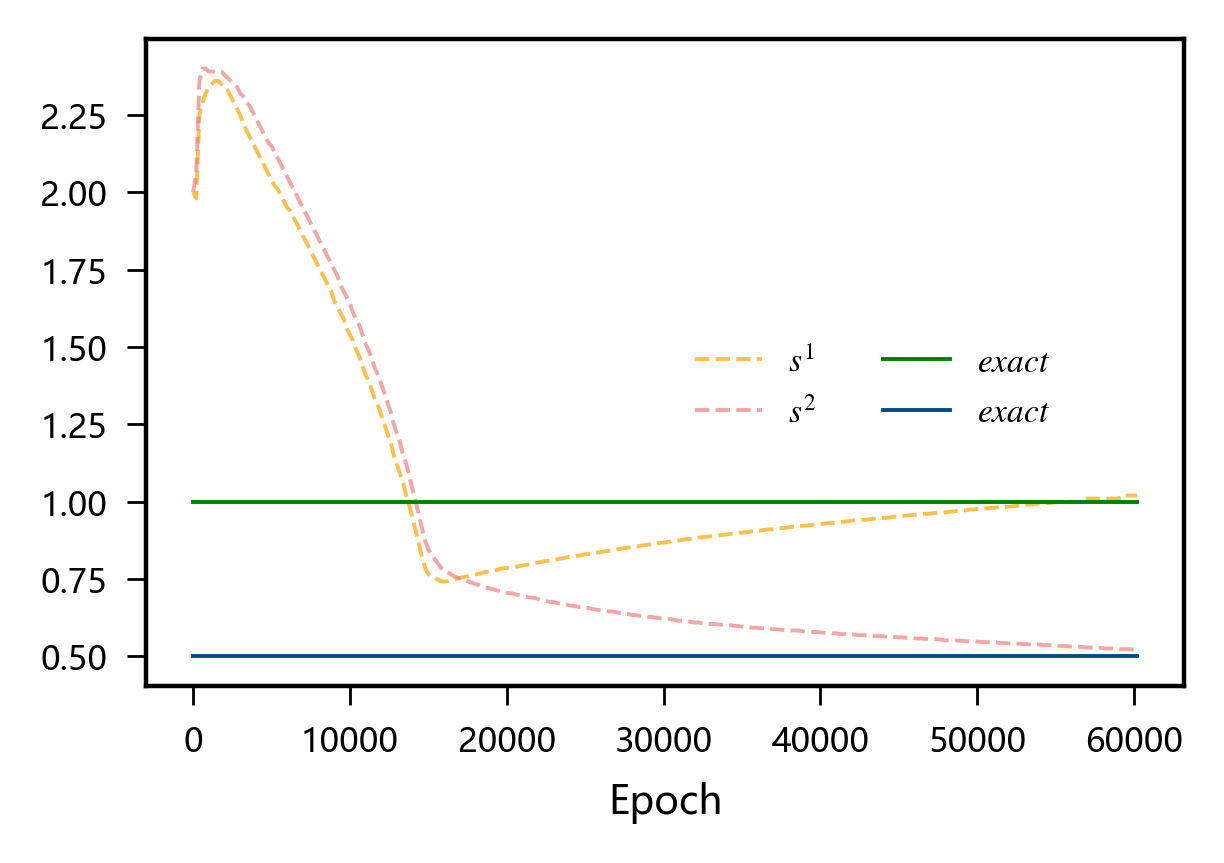

[1.02  0.522]


In [12]:
# model.compile("adam",1e-4,loss_weights=list(Weight.ravel()),loss = loss)
losshistory, train_state = model.train(epochs=40000, callbacks=[variable])
import re
lines = open("s.dat", "r").readlines()
S = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
markersize = 10
markevery = 50
plt.figure()
l = S.shape[0]
width, height, dpi = 3.35, 2.1, 200
plt.figure(figsize=(width,height),dpi = dpi)
markersize = 2
markevery = 20
plt.plot(range(0, 200 * l, 200), S[:,6:7], linestyle='dashed',alpha=0.7,linewidth=0.7, \
        label="$s^1$",color='orange')
plt.plot(range(0, 200 * l, 200), S[:,7:8], linestyle='dashed',alpha=0.7,linewidth=0.7, \
         label="$s^2$",color='lightcoral')
plt.plot(range(0, 200 * l, 200), S[:,0:1]*0+1,linewidth=0.7, label="$exact$",color='green')
plt.plot(range(0, 200 * l, 200), S[:,0:1]*0+0.5,linewidth=0.7, label="$exact$",color='#004B8B')
plt.tick_params(width=0.5, labelsize=6)
plt.xlabel('Epoch', fontsize=7)
plt.legend(fontsize=6,frameon=False,bbox_to_anchor=(0.5, 0.35), ncol=2)
plt.savefig('ex3_s.png',bbox_inches='tight', dpi=800)
plt.show()
data_s = np.hstack((np.array([range(0, 200 * l, 200)]).reshape(-1,1),S))
print(data_s[-1, 7:9])

Compiling model...
'compile' took 64.862537 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
60000     [3.04e-05, 3.01e-05, 8.18e-05, 5.54e-05, 6.39e-05, 3.81e-05, 5.39e-05, 9.72e-05, 1.29e-04, 1.98e-04, 4.93e-04, 6.58e-06, 2.67e-05]    [3.04e-05, 3.01e-05, 8.18e-05, 5.54e-05, 6.39e-05, 3.81e-05, 5.39e-05, 9.72e-05, 1.29e-04, 1.98e-04, 4.93e-04, 6.58e-06, 2.67e-05]    []  
61000     [5.51e-06, 4.02e-06, 3.51e-05, 4.50e-05, 3.42e-05, 2.21e-05, 5.49e-05, 4.96e-05, 7.40e-05, 1.51e-04, 1.13e-04, 2.33e-05, 1.06e-05]    [5.51e-06, 4.02e-06, 3.51e-05, 4.50e-05, 3.42e-05, 2.21e-05, 5.49e-05, 4.96e-05, 7.40e-05, 1.51e-04, 1.13e-04, 2.33e-05, 1.06e-05]    []  
62000     [5.86e-06, 4.36e-06, 3.28e-05, 4.41e-05, 3.36e-05, 2.28e-05, 5.52e-0

<Figure size 640x480 with 0 Axes>

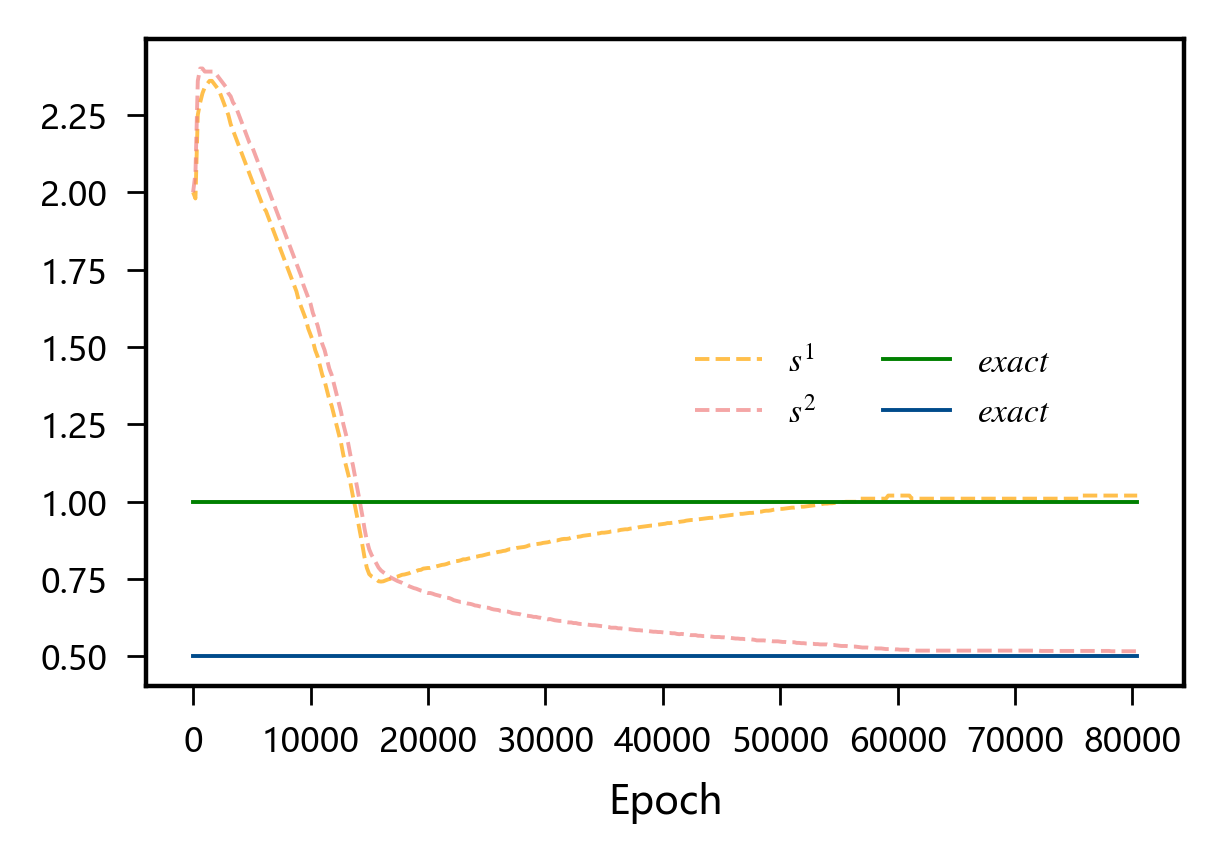

[1.02  0.517]


In [13]:
model.compile("adam",1e-4,loss_weights=list(Weight.ravel()),loss = loss)
losshistory, train_state = model.train(epochs=20000, callbacks=[variable])
import re
lines = open("s.dat", "r").readlines()
S = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
markersize = 10
markevery = 50
plt.figure()
l = S.shape[0]
width, height, dpi = 3.35, 2.1, 200
plt.figure(figsize=(width,height),dpi = dpi)
markersize = 2
markevery = 20
plt.plot(range(0, 200 * l, 200), S[:,6:7], linestyle='dashed',alpha=0.7,linewidth=0.7, \
        label="$s^1$",color='orange')
plt.plot(range(0, 200 * l, 200), S[:,7:8], linestyle='dashed',alpha=0.7,linewidth=0.7, \
         label="$s^2$",color='lightcoral')
plt.plot(range(0, 200 * l, 200), S[:,0:1]*0+1,linewidth=0.7, label="$exact$",color='green')
plt.plot(range(0, 200 * l, 200), S[:,0:1]*0+0.5,linewidth=0.7, label="$exact$",color='#004B8B')
plt.tick_params(width=0.5, labelsize=6)
plt.xlabel('Epoch', fontsize=7)
plt.legend(fontsize=6,frameon=False,bbox_to_anchor=(0.5, 0.35), ncol=2)
plt.savefig('ex3_s.png',bbox_inches='tight', dpi=800)
plt.show()
data_s = np.hstack((np.array([range(0, 200 * l, 200)]).reshape(-1,1),S))
print(data_s[-1, 7:9])

Adding new point: [[0.50063425 0.21101597]
 [0.50291026 0.2086094 ]
 [0.50326015 0.20850942]
 [0.50620115 0.20748653]
 [0.50919856 0.2035607 ]
 [0.51052269 0.20185813]
 [0.50344641 0.22119332]
 [0.50989901 0.21140531]
 [0.50992573 0.21218879]
 [0.50238022 0.23263181]
 [0.51575049 0.20907081]
 [0.50236278 0.79568842]
 [0.50252115 0.79541841]
 [0.51338017 0.21806328]
 [0.50409599 0.23988812]
 [0.50574561 0.79854364]
 [0.50399256 0.79320518]
 [0.50074115 0.77654241]
 [0.50069342 0.77471128]
 [0.5118263  0.22839829]
 [0.51379831 0.22132419]
 [0.51315816 0.22583603]
 [0.5184408  0.21046655]
 [0.50696061 0.798035  ]
 [0.51840851 0.21258954]
 [0.50078269 0.77055697]
 [0.50391252 0.78517511]
 [0.51583983 0.22333974]
 [0.50528255 0.7905764 ]
 [0.50321209 0.24852079]
 [0.50785724 0.79690402]
 [0.50332303 0.77903034]
 [0.51965914 0.21532813]
 [0.52107076 0.21020501]
 [0.51867845 0.2215492 ]
 [0.52244501 0.20164313]
 [0.52147172 0.20638865]
 [0.51437328 0.23548913]
 [0.51346687 0.23765587]
 [0.508

2025-04-08 09:58:08.797268: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


81000     [4.95e-06, 4.33e-06, 3.16e-05, 4.45e-05, 3.65e-05, 2.40e-05, 7.66e-05, 3.86e-05, 6.03e-05, 1.99e-04, 7.91e-05, 2.44e-05, 9.12e-06]    [4.76e-06, 4.01e-06, 3.08e-05, 3.98e-05, 3.51e-05, 2.43e-05, 5.78e-05, 4.45e-05, 6.55e-05, 1.65e-04, 1.00e-04, 2.44e-05, 9.12e-06]    []  
82000     [6.26e-06, 4.85e-06, 3.33e-05, 4.56e-05, 3.52e-05, 2.45e-05, 7.61e-05, 3.85e-05, 6.17e-05, 1.93e-04, 7.53e-05, 2.45e-05, 9.64e-06]    [6.61e-06, 4.37e-06, 3.15e-05, 4.17e-05, 3.49e-05, 2.53e-05, 5.72e-05, 4.43e-05, 6.74e-05, 1.69e-04, 1.12e-04, 2.45e-05, 9.64e-06]    []  
83000     [4.57e-06, 4.71e-06, 3.11e-05, 4.49e-05, 3.74e-05, 2.36e-05, 7.57e-05, 3.84e-05, 6.02e-05, 1.89e-04, 8.37e-05, 2.51e-05, 9.25e-06]    [4.71e-06, 4.43e-06, 3.08e-05, 4.01e-05, 3.83e-05, 2.47e-05, 5.85e-05, 4.51e-05, 6.65e-05, 1.68e-04, 1.25e-04, 2.51e-05, 9.25e-06]    []  
84000     [4.94e-06, 3.99e-06, 3.05e-05, 4.44e-05, 3.26e-05, 2.35e-05, 7.57e-05, 3.69e-05, 6.00e-05, 1.86e-04, 6.25e-05, 2.53e-05, 9.16e-06]    [4.90e-

<Figure size 640x480 with 0 Axes>

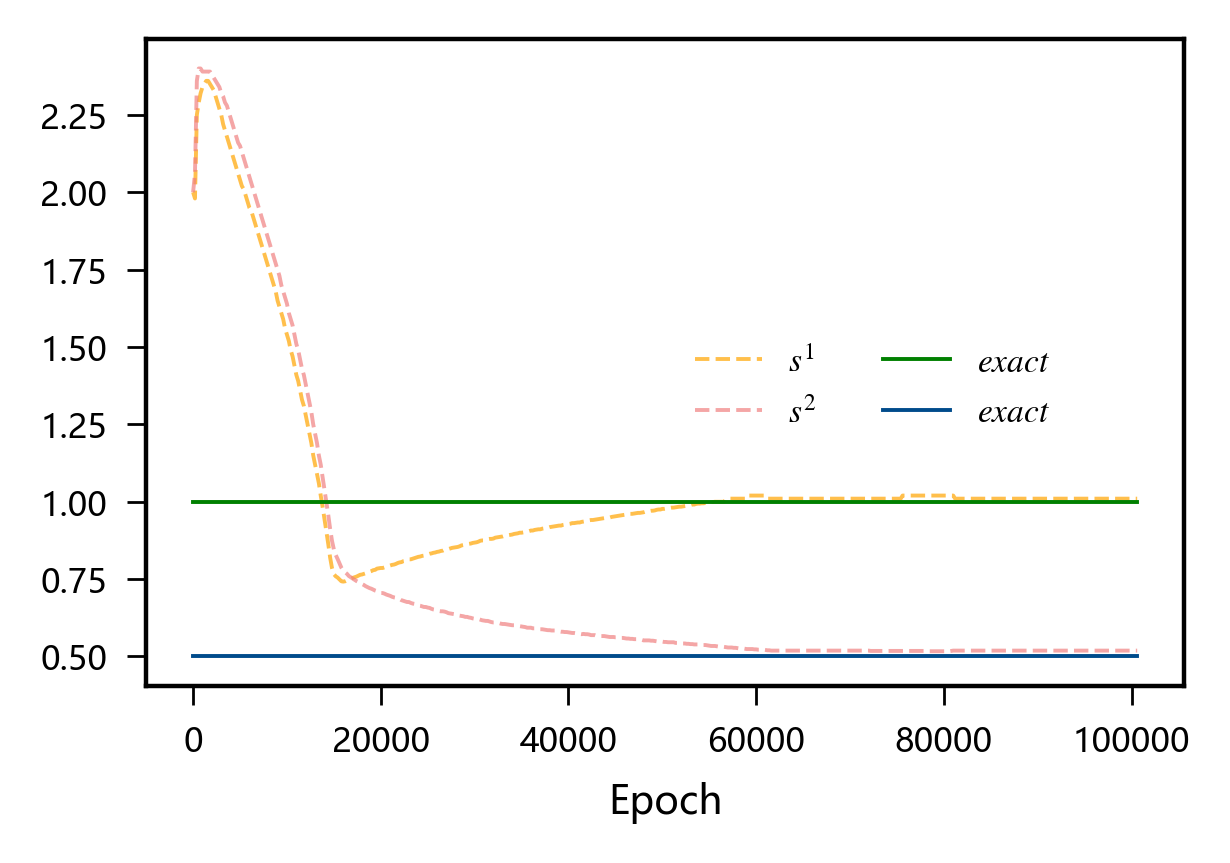

[1.01  0.519]


In [16]:
list_point = []
List_weight = []

x1 = np.random.uniform(0.2,0.8,10000).reshape(-1,1)
x2 = np.random.uniform(0.2,0.8,10000).reshape(-1,1)
X = np.hstack((x1,x2))
X_anchor = geom.random_points(2000)
data.replace_with_anchors(X_anchor)
err_total = np.abs(model.predict(X, operator=platepde))
err_eq = np.sum((err_total),axis=0)
x_ids = np.argsort(-err_eq,axis=0 )[:200]
print("Adding new point:", X[x_ids].reshape(-1,2))
data.add_anchors(X[x_ids].reshape(-1,2))
# model.compile("adam", 1e-4,loss_weights=list(Weight.ravel()),loss = loss)
losshistory, train_state = model.train(epochs=20000, callbacks=[variable])
list_point.append(X[x_ids].reshape(-1,2))
List_weight.append(Weight)

import re
lines = open("s.dat", "r").readlines()
S = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
markersize = 10
markevery = 50
plt.figure()
l = S.shape[0]
width, height, dpi = 3.35, 2.1, 200
plt.figure(figsize=(width,height),dpi = dpi)
markersize = 2
markevery = 20
plt.plot(range(0, 200 * l, 200), S[:,6:7], linestyle='dashed',alpha=0.7,linewidth=0.7, \
        label="$s^1$",color='orange')
plt.plot(range(0, 200 * l, 200), S[:,7:8], linestyle='dashed',alpha=0.7,linewidth=0.7, \
         label="$s^2$",color='lightcoral')
plt.plot(range(0, 200 * l, 200), S[:,0:1]*0+1,linewidth=0.7, label="$exact$",color='green')
plt.plot(range(0, 200 * l, 200), S[:,0:1]*0+0.5,linewidth=0.7, label="$exact$",color='#004B8B')
plt.tick_params(width=0.5, labelsize=6)
plt.xlabel('Epoch', fontsize=7)
plt.legend(fontsize=6,frameon=False,bbox_to_anchor=(0.5, 0.35), ncol=2)
plt.savefig('ex3_s.png',bbox_inches='tight', dpi=800)
plt.show()
data_s = np.hstack((np.array([range(0, 200 * l, 200)]).reshape(-1,1),S))
print(data_s[-1, 7:9])